In [49]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('Dataset_main.csv', parse_dates=['datetime'])
# Step 1: Effective Irradiance for Zone 03

bifaciality_factor = 0.7

# Fill nulls first (if not done before) to avoid NaNs messing up the sum
df['meteorolgicas_em_03_02_gii'] = df['meteorolgicas_em_03_02_gii'].fillna(0)
df['meteorolgicas_em_03_02_gii_rear'] = df['meteorolgicas_em_03_02_gii_rear'].fillna(0)

df['Effective_Irradiance_03'] = (
    df['meteorolgicas_em_03_02_gii'] + 
    (df['meteorolgicas_em_03_02_gii_rear'] * bifaciality_factor)
)

print("✅ Step 1 complete: Effective_Irradiance_03 calculated.")


✅ Step 1 complete: Effective_Irradiance_03 calculated.


In [51]:
# Step 2: Calculate panel area for Inverter 03
stc_irradiance = 1000  # W/m²
assumed_stc_efficiency = 0.22  # 20%                             # assumed_stc_efficiency = 0.21
rated_power_inv03 = 3800 * 1000  # Watts

panel_area_inv03 = rated_power_inv03 / (stc_irradiance * assumed_stc_efficiency)

print(f"✅ Step 2 complete: Assumed Panel Area for Inverter 03 = {panel_area_inv03:.2f} m²")


✅ Step 2 complete: Assumed Panel Area for Inverter 03 = 17272.73 m²


In [53]:
# Step 3: Calculate the theoretical DC power in Watts
df['Theoretical_Power_Inv03_W'] = df['Effective_Irradiance_03'] * panel_area_inv03 * assumed_stc_efficiency

# Convert to MW
df['Theoretical_Power_Inv03_MW'] = df['Theoretical_Power_Inv03_W'] / 1_000_000

print("✅ Step 3 complete: Theoretical_Power_Inv03_MW calculated")


✅ Step 3 complete: Theoretical_Power_Inv03_MW calculated


In [55]:
# Step 4.1: Effective Irradiance for Inverter 08 zone
df['Effective_Irradiance_08'] = df['meteorolgicas_em_08_01_gii'] + (df['meteorolgicas_em_08_01_gii_rear'] * bifaciality_factor)

print("✅ Step 4.1 complete: Effective_Irradiance_08 calculated")


✅ Step 4.1 complete: Effective_Irradiance_08 calculated


In [57]:
# Area is the same as Inv03 since rated power is identical
panel_area_inv08 = panel_area_inv03  

# Step 4.2: Calculate theoretical power in Watts
df['Theoretical_Power_Inv08_W'] = df['Effective_Irradiance_08'] * panel_area_inv08 * assumed_stc_efficiency

# Convert to MW
df['Theoretical_Power_Inv08_MW'] = df['Theoretical_Power_Inv08_W'] / 1_000_000

print("✅ Step 4.2 complete: Theoretical_Power_Inv08_MW calculated")

✅ Step 4.2 complete: Theoretical_Power_Inv08_MW calculated


In [59]:
# Step 5: Total theoretical plant power in MW
df['Total_Theoretical_Power_MW'] = df['Theoretical_Power_Inv03_MW'] + df['Theoretical_Power_Inv08_MW']

print("✅ Step 5 complete: Total_Theoretical_Power_MW calculated")


✅ Step 5 complete: Total_Theoretical_Power_MW calculated


In [61]:
# Convert datetime column to datetime dtype if not already
df['datetime'] = pd.to_datetime(df['datetime'])

# Set as index
df = df.set_index('datetime')

print(f"✅ Index is now datetime: {df.index}")


✅ Index is now datetime: DatetimeIndex(['2024-10-01 00:00:00', '2024-10-01 00:15:00',
               '2024-10-01 00:30:00', '2024-10-01 00:45:00',
               '2024-10-01 01:00:00', '2024-10-01 01:15:00',
               '2024-10-01 01:30:00', '2024-10-01 01:45:00',
               '2024-10-01 02:00:00', '2024-10-01 02:15:00',
               ...
               '2025-03-31 21:30:00', '2025-03-31 21:45:00',
               '2025-03-31 22:00:00', '2025-03-31 22:15:00',
               '2025-03-31 22:30:00', '2025-03-31 22:45:00',
               '2025-03-31 23:00:00', '2025-03-31 23:15:00',
               '2025-03-31 23:30:00', '2025-03-31 23:45:00'],
              dtype='datetime64[ns]', name='datetime', length=17472, freq=None)


Data points for 2025-02-2: 96


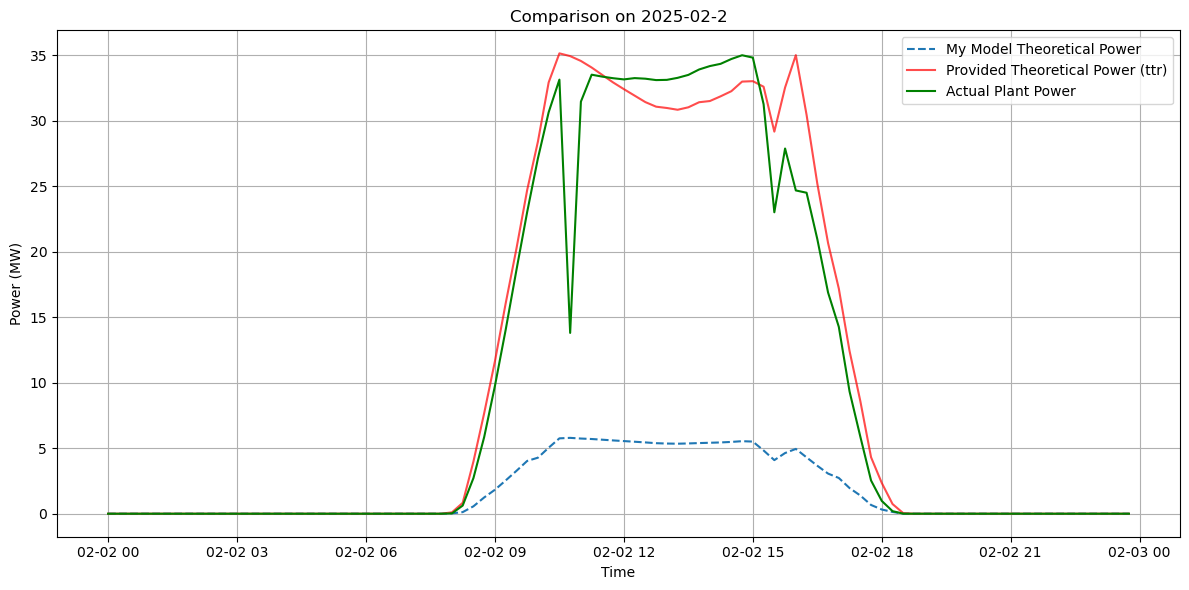

📊 Step 6 complete: Sanity check plot generated!


In [63]:
import matplotlib.pyplot as plt

# Example date – adjust if needed to a day with good data
plot_date = '2025-02-2'

# Filter data for that date
df_plot = df.loc[df.index.normalize() == pd.to_datetime(plot_date)]

# Make sure data is available
print(f"Data points for {plot_date}: {len(df_plot)}")

plt.figure(figsize=(12, 6))
plt.plot(df_plot.index, df_plot['Total_Theoretical_Power_MW'], label='My Model Theoretical Power', linestyle='--')
plt.plot(df_plot.index, df_plot['ttr_potenciaproducible'], label='Provided Theoretical Power (ttr)', color='red', alpha=0.7)
plt.plot(df_plot.index, df_plot['ppc_p_tot'], label='Actual Plant Power', color='green')
plt.title(f'Comparison on {plot_date}')
plt.ylabel('Power (MW)')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("📊 Step 6 complete: Sanity check plot generated!")


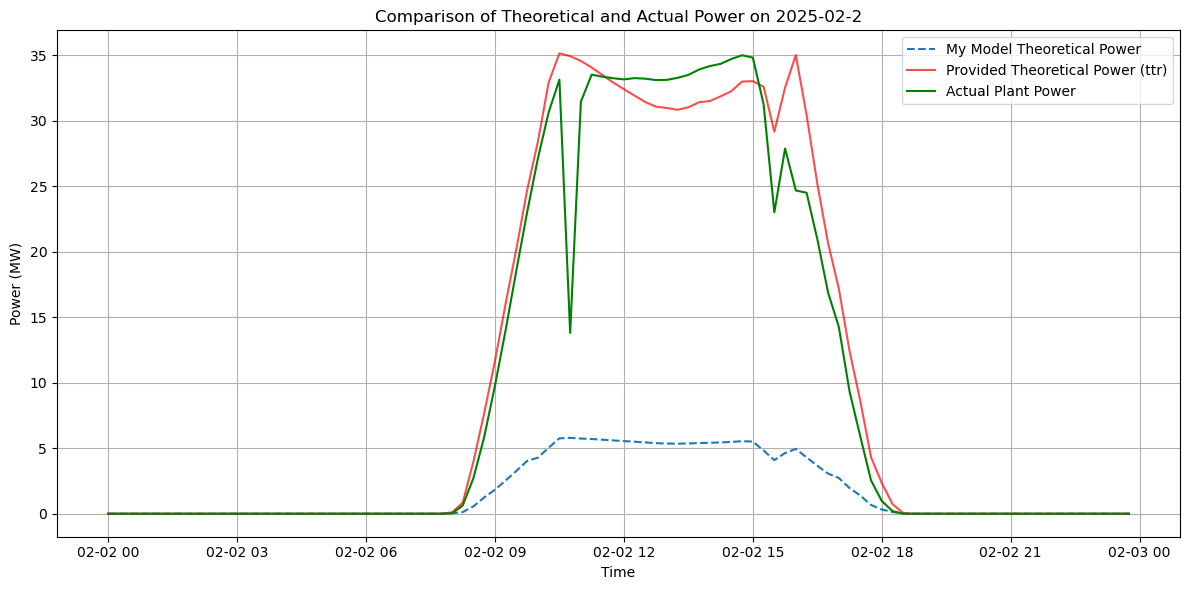

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df_plot.index, df_plot['Total_Theoretical_Power_MW'], label='My Model Theoretical Power', linestyle='--')
plt.plot(df_plot.index, df_plot['ttr_potenciaproducible'], label='Provided Theoretical Power (ttr)', color='red', alpha=0.7)
plt.plot(df_plot.index, df_plot['ppc_p_tot'], label='Actual Plant Power', color='green')

plt.title(f'Comparison of Theoretical and Actual Power on {plot_date}')
plt.ylabel('Power (MW)')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [67]:
# Temperature coefficient (per °C)
temp_coeff = -0.004

# Module temperature column for Zone 03
t_mod_col_03 = 'celulas_ctin03_cc_03_1_t_mod'

# Compute correction factor
df['Temp_Correction_Factor_03'] = 1 + (df[t_mod_col_03] - 25) * temp_coeff

# Apply correction to theoretical power
df['Temp_Corrected_Theoretical_Power_Inv03_MW'] = df['Theoretical_Power_Inv03_MW'] * df['Temp_Correction_Factor_03']


In [69]:
# Module temperature column for Zone 08
t_mod_col_08 = 'celulas_ctin08_cc_08_1_t_mod'

# Compute correction factor
df['Temp_Correction_Factor_08'] = 1 + (df[t_mod_col_08] - 25) * temp_coeff

# Apply correction to theoretical power
df['Temp_Corrected_Theoretical_Power_Inv08_MW'] = df['Theoretical_Power_Inv08_MW'] * df['Temp_Correction_Factor_08']


In [71]:
# Total temperature-corrected theoretical power (MW)
df['Total_Temp_Corrected_Theoretical_Power_MW'] = (
    df['Temp_Corrected_Theoretical_Power_Inv03_MW'] + 
    df['Temp_Corrected_Theoretical_Power_Inv08_MW']
)


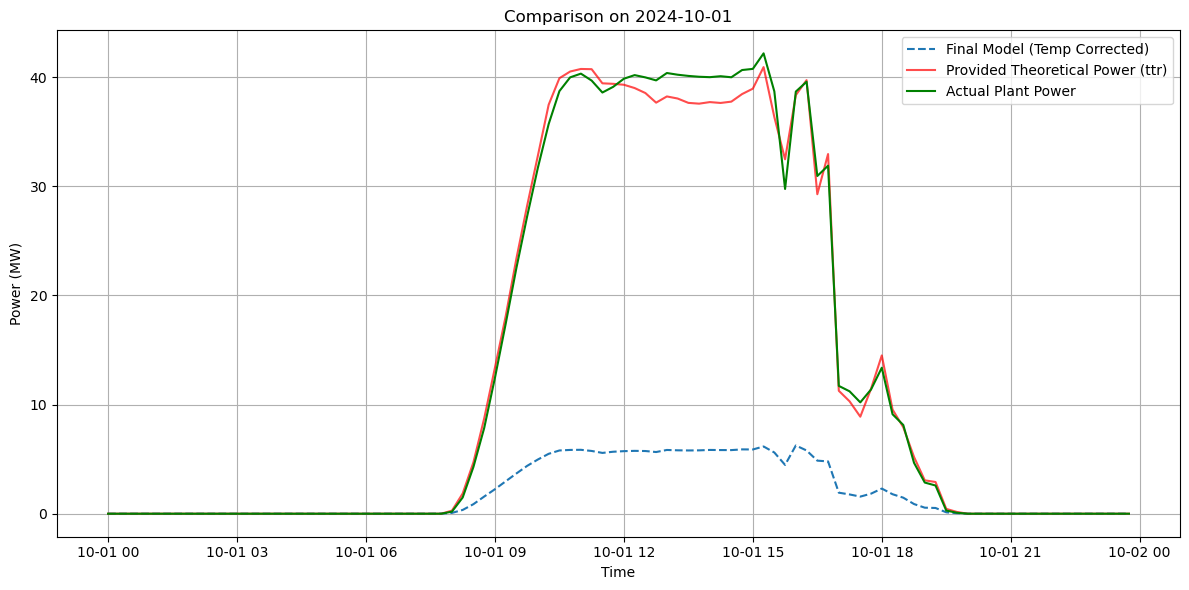

📊 Plot done! ✅


In [75]:
import matplotlib.pyplot as plt

# Pick a day to plot
plot_date = '2024-10-01'

# Make sure datetime index is correct
df.index = pd.to_datetime(df.index)

# Filter data for that day
df_plot = df.loc[df.index.normalize() == pd.to_datetime(plot_date)]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_plot.index, df_plot['Total_Temp_Corrected_Theoretical_Power_MW'], label='Final Model (Temp Corrected)', linestyle='--')
plt.plot(df_plot.index, df_plot['ttr_potenciaproducible'], label='Provided Theoretical Power (ttr)', color='red', alpha=0.7)
plt.plot(df_plot.index, df_plot['ppc_p_tot'], label='Actual Plant Power', color='green')
plt.title(f'Comparison on {plot_date}')
plt.ylabel('Power (MW)')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("📊 Plot done! ✅")


In [77]:
# Step 1: Assign actual generation at plant level
df['Actual_Plant_Power_MW'] = df['ppc_p_tot']


In [79]:
# Step 2: Calculate total loss at plant level (in MW)
df['Total_Loss_MW'] = df['Total_Theoretical_Power_MW'] - df['Actual_Plant_Power_MW']


In [81]:
# Step 3a: Calculate energy generated in each 15-min interval by inverter 03
df['inv03_interval_energy_MWh'] = df['inversores_ctin03_inv_03_03_eact_tot'].diff()

# Step 3b: Handle counter resets or negative jumps by replacing negatives with 0
df.loc[df['inv03_interval_energy_MWh'] < 0, 'inv03_interval_energy_MWh'] = 0

# Step 3c: Convert interval energy to average power over 15 minutes (0.25 hour)
df['Actual_Power_Inv03_MW'] = df['inv03_interval_energy_MWh'] / 0.25


In [83]:
# Step 4a: Calculate energy generated in each 15-min interval by inverter 08
df['inv08_interval_energy_MWh'] = df['inversores_ctin08_inv_08_08_eact_tot'].diff()

# Step 4b: Handle counter resets or negative jumps by replacing negatives with 0
df.loc[df['inv08_interval_energy_MWh'] < 0, 'inv08_interval_energy_MWh'] = 0

# Step 4c: Convert interval energy to average power over 15 minutes (0.25 hour)
df['Actual_Power_Inv08_MW'] = df['inv08_interval_energy_MWh'] / 0.25


In [85]:
# Step 5: Calculate total actual inverter-level power by summing both inverters
df['Actual_Inverters_Total_Power_MW'] = df['Actual_Power_Inv03_MW'] + df['Actual_Power_Inv08_MW']


<Axes: xlabel='datetime'>

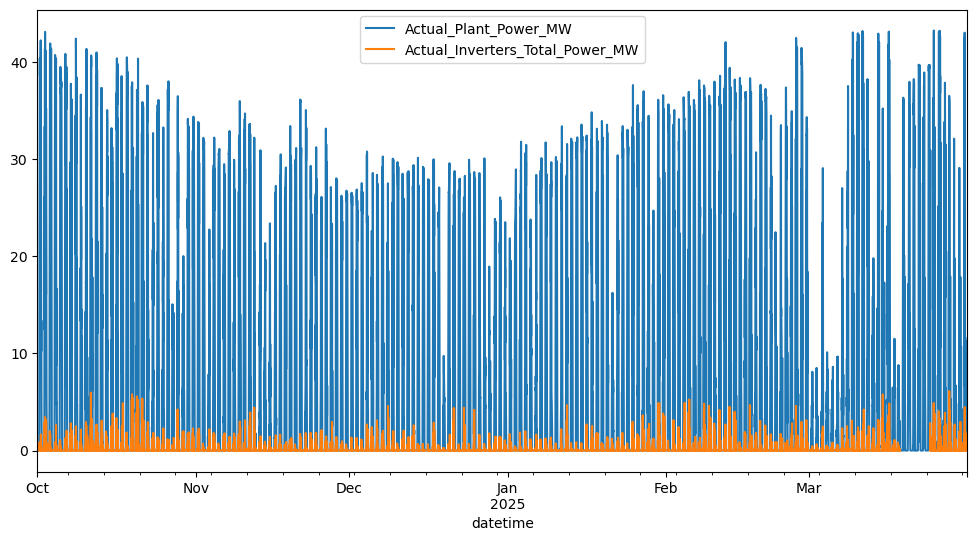

In [87]:
# Quick check: compare plant-level actual vs sum of inverters
df[['Actual_Plant_Power_MW', 'Actual_Inverters_Total_Power_MW']].plot(figsize=(12,6))


In [89]:
# Flag large dips in irradiance as possible cloud cover losses
irradiance_threshold = 200  # adjust based on data and typical site irradiance
df['Flag_CloudCover'] = df['meteorolgicas_em_03_02_gii'] < irradiance_threshold


In [91]:
# Difference between target and actual tracker position
df['Tracker_Angle_Error'] = abs(df['seguidores_ct03_gcu031_t0308035_pos_obj'] - df['seguidores_ct03_gcu031_t0308035_pos_ang'])

# Flag if error is large (e.g., > 10 degrees)
df['Flag_Shading_Or_Tracking'] = df['Tracker_Angle_Error'] > 10


In [93]:
# Flag high module temperature (> 60°C as an example; adjust as per module spec)
df['Flag_High_Temperature'] = df['celulas_ctin03_cc_03_1_t_mod'] > 60


In [95]:
# Initialize loss columns
df['Loss_CloudCover_MW'] = 0.0
df['Loss_ShadingOrTracking_MW'] = 0.0
df['Loss_HighTemp_MW'] = 0.0
df['Loss_Unexplained_MW'] = 0.0

# Allocate losses based on flags
df.loc[df['Flag_CloudCover'], 'Loss_CloudCover_MW'] = df['Total_Loss_MW']
df.loc[(~df['Flag_CloudCover']) & df['Flag_Shading_Or_Tracking'], 'Loss_ShadingOrTracking_MW'] = df['Total_Loss_MW']
df.loc[(~df['Flag_CloudCover']) & (~df['Flag_Shading_Or_Tracking']) & df['Flag_High_Temperature'], 'Loss_HighTemp_MW'] = df['Total_Loss_MW']

# Remaining unexplained losses
df['Loss_Unexplained_MW'] = df['Total_Loss_MW'] - (
    df['Loss_CloudCover_MW'] + df['Loss_ShadingOrTracking_MW'] + df['Loss_HighTemp_MW']
)


In [107]:
print(df.columns.tolist())


['meteorolgicas_em_03_02_gii', 'meteorolgicas_em_08_01_gii', 'meteorolgicas_em_03_02_ghi', 'meteorolgicas_em_08_01_ghi', 'meteorolgicas_em_08_01_gii_rear', 'meteorolgicas_em_03_02_gii_rear', 'meteorolgicas_em_03_02_desviacin_incidente', 'meteorolgicas_em_08_01_desviacin_incidente', 'meteorolgicas_em_03_02_t_amb', 'meteorolgicas_em_08_01_t_amb', 'meteorolgicas_em_03_02_h_r', 'meteorolgicas_em_08_01_h_r', 'meteorolgicas_em_03_02_t_dlogger', 'meteorolgicas_em_08_01_t_dlogger', 'meteorolgicas_em_08_01_ws', 'meteorolgicas_em_03_02_ws', 'meteorolgicas_em_08_01_wd', 'meteorolgicas_em_03_02_wd', 'celulas_ctin08_cc_08_1_ir_cel_1', 'celulas_ctin08_cc_08_2_ir_cel_1', 'celulas_ctin03_cc_03_1_ir_cel_1', 'celulas_ctin03_cc_03_2_ir_cel_1', 'celulas_ctin08_cc_08_2_ir_cel_2', 'celulas_ctin03_cc_03_2_ir_cel_2', 'celulas_ctin03_cc_03_1_ir_cel_2', 'celulas_ctin08_cc_08_1_ir_cel_2', 'celulas_ctin08_cc_08_2_t_amb', 'celulas_ctin03_cc_03_1_t_amb', 'celulas_ctin08_cc_08_1_t_amb', 'celulas_ctin03_cc_03_2_t_amb

In [109]:
df = df.reset_index()


In [111]:
print(df.columns.tolist())

['datetime', 'meteorolgicas_em_03_02_gii', 'meteorolgicas_em_08_01_gii', 'meteorolgicas_em_03_02_ghi', 'meteorolgicas_em_08_01_ghi', 'meteorolgicas_em_08_01_gii_rear', 'meteorolgicas_em_03_02_gii_rear', 'meteorolgicas_em_03_02_desviacin_incidente', 'meteorolgicas_em_08_01_desviacin_incidente', 'meteorolgicas_em_03_02_t_amb', 'meteorolgicas_em_08_01_t_amb', 'meteorolgicas_em_03_02_h_r', 'meteorolgicas_em_08_01_h_r', 'meteorolgicas_em_03_02_t_dlogger', 'meteorolgicas_em_08_01_t_dlogger', 'meteorolgicas_em_08_01_ws', 'meteorolgicas_em_03_02_ws', 'meteorolgicas_em_08_01_wd', 'meteorolgicas_em_03_02_wd', 'celulas_ctin08_cc_08_1_ir_cel_1', 'celulas_ctin08_cc_08_2_ir_cel_1', 'celulas_ctin03_cc_03_1_ir_cel_1', 'celulas_ctin03_cc_03_2_ir_cel_1', 'celulas_ctin08_cc_08_2_ir_cel_2', 'celulas_ctin03_cc_03_2_ir_cel_2', 'celulas_ctin03_cc_03_1_ir_cel_2', 'celulas_ctin08_cc_08_1_ir_cel_2', 'celulas_ctin08_cc_08_2_t_amb', 'celulas_ctin03_cc_03_1_t_amb', 'celulas_ctin08_cc_08_1_t_amb', 'celulas_ctin03_c

In [113]:
# Convert 'datetime' column to proper datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Create a new column with just the date part
df['date'] = df['datetime'].dt.date


# Daily sum of each loss category
daily_losses = df.groupby('date')[
    ['Loss_CloudCover_MW', 'Loss_ShadingOrTracking_MW', 'Loss_HighTemp_MW', 'Loss_Unexplained_MW']
].sum().reset_index()


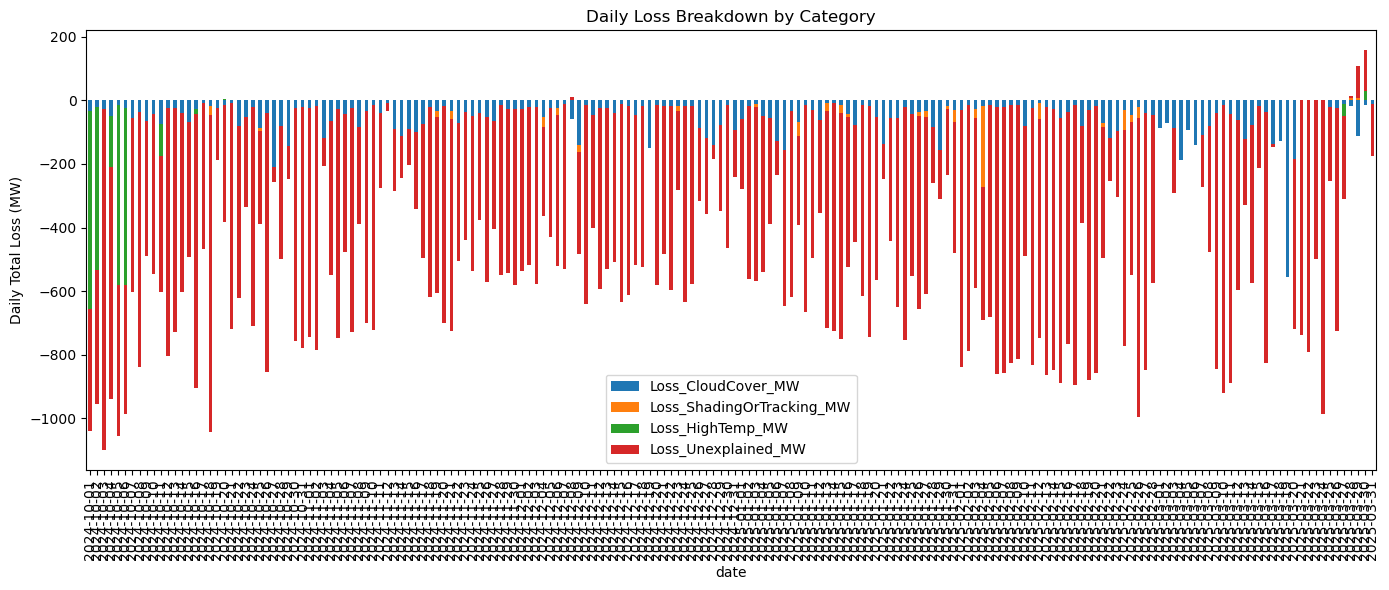

In [115]:
import matplotlib.pyplot as plt

daily_losses.set_index('date').plot(
    kind='bar', stacked=True, figsize=(14,6),
    ylabel='Daily Total Loss (MW)',
    title='Daily Loss Breakdown by Category'
)

plt.tight_layout()
plt.show()


In [119]:
df.to_csv('current_dataset.csv')

In [121]:
# Make sure total_panel_area is defined
total_panel_area = panel_area_inv03 + panel_area_inv08

# Power at STC in MW (should be constant)
df['Power_at_STC_MW'] = (stc_irradiance * total_panel_area * assumed_stc_efficiency) / 1_000_000

print(f"✅ Power at STC (constant): {df['Power_at_STC_MW'].iloc[0]:.2f} MW")


✅ Power at STC (constant): 7.60 MW


In [125]:
# Calculate irradiance loss
df['Loss_Irradiance_MW'] = df['Power_at_STC_MW'] - df['Total_Theoretical_Power_MW']

# Set irradiance loss to 0 during night
df.loc[~df['is_daytime'], 'Loss_Irradiance_MW'] = 0

print("✅ Irradiance loss calculated and night time handled.")


✅ Irradiance loss calculated and night time handled.


In [127]:
# Using an average of the two main GHI sensors for a robust plant-wide metric
avg_ghi = df[['meteorolgicas_em_03_02_ghi', 'meteorolgicas_em_08_01_ghi']].mean(axis=1)

# Create the cloud cover flag: if irradiance loss is more than 10% of perfect power
df['Flag_CloudCover'] = (df['Loss_Irradiance_MW'] > 0.1 * df['Power_at_STC_MW']).astype(int)

print("✅ Step 4.1C complete: Flag_CloudCover column created.")


✅ Step 4.1C complete: Flag_CloudCover column created.


In [129]:
# Calculate soiling ratio for each station
df['soiling_ratio_ct03_cc031'] = df['celulas_ctin03_cc_03_1_ir_cel_1'] / df['celulas_ctin03_cc_03_1_ir_cel_2']
df['soiling_ratio_ct03_cc032'] = df['celulas_ctin03_cc_03_2_ir_cel_1'] / df['celulas_ctin03_cc_03_2_ir_cel_2']
df['soiling_ratio_ct08_cc081'] = df['celulas_ctin08_cc_08_1_ir_cel_1'] / df['celulas_ctin08_cc_08_1_ir_cel_2']
df['soiling_ratio_ct08_cc082'] = df['celulas_ctin08_cc_08_2_ir_cel_1'] / df['celulas_ctin08_cc_08_2_ir_cel_2']

print("✅ Step 4.2A complete: Soiling ratios calculated for each station.")


✅ Step 4.2A complete: Soiling ratios calculated for each station.


In [131]:
# List of soiling ratio columns
soiling_cols = [
    'soiling_ratio_ct03_cc031',
    'soiling_ratio_ct03_cc032',
    'soiling_ratio_ct08_cc081',
    'soiling_ratio_ct08_cc082'
]

for col in soiling_cols:
    # Replace inf and -inf with NaN
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    # Clip max at 1.0 (dirty cell can't be cleaner than clean)
    df[col] = df[col].clip(upper=1.0)

# Compute average soiling ratio, ignoring NaNs
df['Avg_Soiling_Ratio'] = df[soiling_cols].mean(axis=1)

# Forward fill to handle missing daytime values
df['Avg_Soiling_Ratio'].fillna(method='ffill', inplace=True)

print("✅ Step 4.2B complete: Avg_Soiling_Ratio calculated and cleaned.")


✅ Step 4.2B complete: Avg_Soiling_Ratio calculated and cleaned.


C:\Users\dell\AppData\Local\Temp\ipykernel_9096\3930829191.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Avg_Soiling_Ratio'].fillna(method='ffill', inplace=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_9096\3930829191.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Avg_Soiling_Ratio'].fillna(method='ffill', inplace=True)


In [133]:
# Power after irradiance loss (before soiling)
power_after_irradiance = df['Total_Theoretical_Power_MW']

# Calculate the power lost due to soiling
df['Loss_Soiling_MW'] = power_after_irradiance * (1 - df['Avg_Soiling_Ratio'])

# Create a boolean flag: significant soiling if ratio < 0.99
df['Flag_Soiling'] = (df['Avg_Soiling_Ratio'] < 0.99).astype(int)

print("✅ Step 4.2C complete: Soiling loss calculated and flagged.")


✅ Step 4.2C complete: Soiling loss calculated and flagged.


In [135]:
# List your module temperature columns
mod_temp_cols = [
    'celulas_ctin03_cc_03_1_t_mod',
    'celulas_ctin03_cc_03_2_t_mod',
    'celulas_ctin08_cc_08_1_t_mod',
    'celulas_ctin08_cc_08_2_t_mod'
]

# Calculate average module temperature
df['Avg_Module_Temp_C'] = df[mod_temp_cols].mean(axis=1)

# Interpolate missing values
df['Avg_Module_Temp_C'].interpolate(method='linear', inplace=True)

print("✅ Step 4.3A complete: Avg_Module_Temp_C calculated and interpolated.")


✅ Step 4.3A complete: Avg_Module_Temp_C calculated and interpolated.


C:\Users\dell\AppData\Local\Temp\ipykernel_9096\470999862.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Avg_Module_Temp_C'].interpolate(method='linear', inplace=True)


In [137]:
# Assumptions
temp_coefficient = -0.0035  # -0.35% per °C
stc_temp = 25  # Standard Test Conditions temperature in °C

# Power after soiling loss
power_after_soiling = df['Total_Theoretical_Power_MW'] - df['Loss_Soiling_MW']

# Temperature derating factor
temp_derate = 1 + (df['Avg_Module_Temp_C'] - stc_temp) * temp_coefficient

# Clip derate at maximum of 1 (modules can't get more efficient than STC in this model)
temp_derate = temp_derate.clip(upper=1.0)

# Temperature loss
df['Loss_Temperature_MW'] = power_after_soiling * (1 - temp_derate)

# Boolean flag: when temperature > STC temperature (panels are hotter)
df['Flag_Temperature'] = (df['Avg_Module_Temp_C'] > stc_temp).astype(int)

print("✅ Step 4.3B complete: Temperature loss calculated and flagged.")


✅ Step 4.3B complete: Temperature loss calculated and flagged.


In [139]:
# Assumed inverter efficiency
inverter_efficiency = 0.985  # 98.5%

# Power after temperature loss
power_after_temp = power_after_soiling - df['Loss_Temperature_MW']

# Expected AC power before clipping
df['Expected_AC_Power_Total_MW'] = power_after_temp * inverter_efficiency

print("✅ Step 4.4A complete: Expected AC power before clipping calculated.")


✅ Step 4.4A complete: Expected AC power before clipping calculated.


In [141]:
# Total rated AC power of the plant: two inverters × 3.8 MW each
rated_ac_power_total = 3.8 + 3.8  # 7.6 MW

# Clipping loss occurs when expected AC power > rated AC power
df['Loss_Clipping_MW'] = (df['Expected_AC_Power_Total_MW'] - rated_ac_power_total).clip(lower=0)

# Create a boolean flag indicating when clipping occurs
df['Flag_Clipping'] = (df['Loss_Clipping_MW'] > 0).astype(int)

print("✅ Step 4.4B complete: Clipping loss and flag created.")


✅ Step 4.4B complete: Clipping loss and flag created.


In [143]:
# Step 5A: Calculate modeled AC power after all known losses
df['Modeled_AC_Power_MW'] = df['Expected_AC_Power_Total_MW'] - df['Loss_Clipping_MW']

# Step 5B: Calculate "Other" losses as the gap between modeled power and actual power
# (Replace 'Actual_Plant_Power_MW' with your actual plant power column name, e.g., 'ppc_p_tot' converted to MW)
df['Actual_Plant_Power_MW'] = df['ppc_p_tot'] / 1000  # assuming ppc_p_tot is in kW

df['Loss_Other_MW'] = df['Modeled_AC_Power_MW'] - df['Actual_Plant_Power_MW']

# Make sure other losses are not negative
df['Loss_Other_MW'] = df['Loss_Other_MW'].clip(lower=0)

# Create flag: mark periods where Other Loss > 5% of modeled power
df['Flag_Other'] = (df['Loss_Other_MW'] > 0.05 * df['Modeled_AC_Power_MW']).astype(int)

print("✅ Step 5 complete: Other losses and flag created.")


✅ Step 5 complete: Other losses and flag created.


In [147]:
# Convert to datetime (if not already)
df['datetime'] = pd.to_datetime(df['datetime'])

# Set as index
df = df.set_index('datetime')

# Confirm
print(df.index)


DatetimeIndex(['2024-10-01 00:00:00', '2024-10-01 00:15:00',
               '2024-10-01 00:30:00', '2024-10-01 00:45:00',
               '2024-10-01 01:00:00', '2024-10-01 01:15:00',
               '2024-10-01 01:30:00', '2024-10-01 01:45:00',
               '2024-10-01 02:00:00', '2024-10-01 02:15:00',
               ...
               '2025-03-31 21:30:00', '2025-03-31 21:45:00',
               '2025-03-31 22:00:00', '2025-03-31 22:15:00',
               '2025-03-31 22:30:00', '2025-03-31 22:45:00',
               '2025-03-31 23:00:00', '2025-03-31 23:15:00',
               '2025-03-31 23:30:00', '2025-03-31 23:45:00'],
              dtype='datetime64[ns]', name='datetime', length=17472, freq=None)


In [149]:
# List of loss columns and main power columns to aggregate
loss_cols = [
    'Loss_Irradiance_MW', 'Loss_Soiling_MW', 'Loss_Temperature_MW',
    'Loss_Clipping_MW', 'Loss_Other_MW'
]
energy_cols = ['Actual_Plant_Power_MW', 'Modeled_AC_Power_MW'] + loss_cols

# Convert average power to daily energy (MWh): sum over day * 0.25h
daily_energy_MWh = df[energy_cols].resample('D').sum() * 0.25

# Show the first few rows
print(daily_energy_MWh.head())


            Actual_Plant_Power_MW  Modeled_AC_Power_MW  Loss_Irradiance_MW  \
datetime                                                                     
2024-10-01               0.314086            47.159315           37.453303   
2024-10-02               0.288534            43.524287           39.495728   
2024-10-03               0.330768            49.886023           33.489252   
2024-10-04               0.282604            42.629909           43.139583   
2024-10-05               0.318073            47.824888           34.930078   

            Loss_Soiling_MW  Loss_Temperature_MW  Loss_Clipping_MW  \
datetime                                                             
2024-10-01         0.230494             5.638726               0.0   
2024-10-02         0.272493             5.351307               0.0   
2024-10-03         0.278795             4.892293               0.0   
2024-10-04         0.285405             4.499594               0.0   
2024-10-05         0.186900      

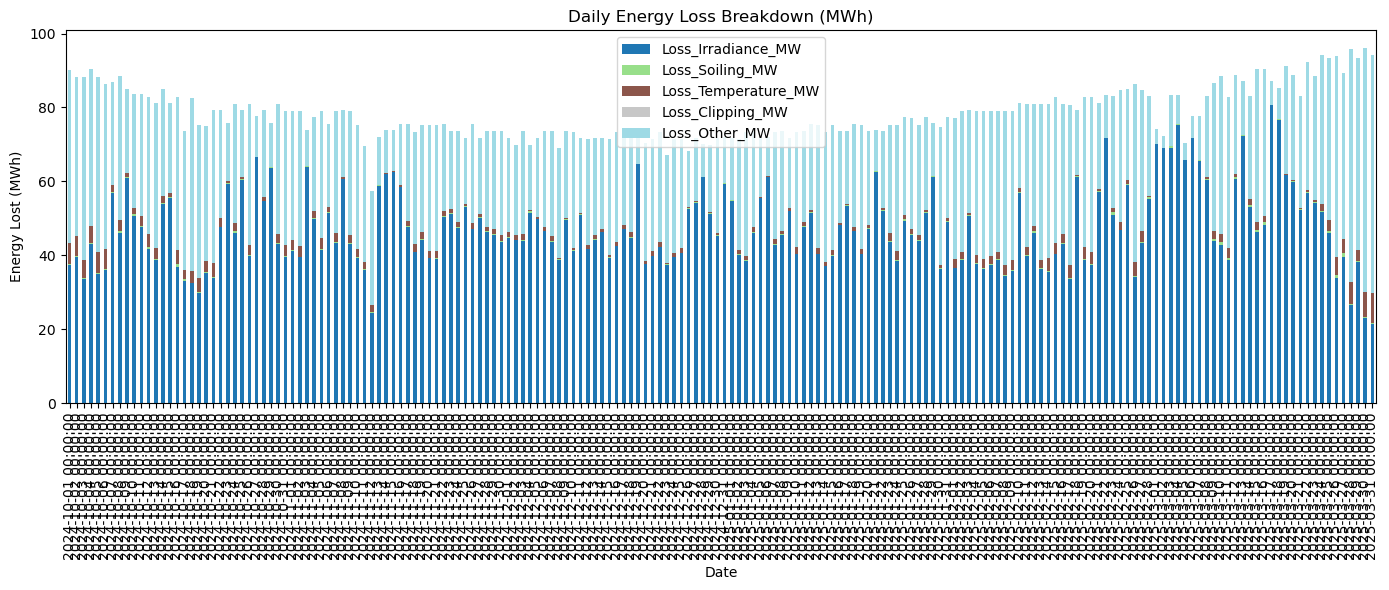

In [151]:
import matplotlib.pyplot as plt

# Plot only loss columns to see the breakdown
daily_energy_MWh[loss_cols].plot(
    kind='bar', stacked=True, figsize=(14,6),
    colormap='tab20'
)

plt.title('Daily Energy Loss Breakdown (MWh)')
plt.ylabel('Energy Lost (MWh)')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


In [153]:
# Export daily data to CSV
daily_energy_MWh.to_csv('daily_energy_losses.csv')

print("✅ Exported daily data to Excel and CSV!")


✅ Exported daily data to Excel and CSV!


In [157]:
# Weekly aggregation: resample by week starting on Monday ('W-MON')
weekly_energy_MWh = df[energy_cols].resample('W-MON').sum() * 0.25

# Monthly aggregation: resample by month
monthly_energy_MWh = df[energy_cols].resample('M').sum() * 0.25

# Export them too
weekly_energy_MWh.to_csv('weekly_energy_losses.csv')
monthly_energy_MWh.to_csv('monthly_energy_losses.csv')

print("✅ Weekly and monthly data created and exported!")


✅ Weekly and monthly data created and exported!


C:\Users\dell\AppData\Local\Temp\ipykernel_9096\1641036981.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_energy_MWh = df[energy_cols].resample('M').sum() * 0.25


In [159]:
# List of power loss columns
power_loss_cols = [
    'Loss_Irradiance_MW', 
    'Loss_Soiling_MW', 
    'Loss_Temperature_MW', 
    'Loss_Clipping_MW', 
    'Loss_Other_MW'
]

# Convert each to MWh by multiplying by 0.25 (each row is 15 mins)
for col in power_loss_cols:
    energy_col = col.replace('_MW', '_MWh')
    df[energy_col] = df[col] * 0.25

# Also create theoretical and actual energy columns
df['Total_Theoretical_Energy_MWh'] = df['Total_Theoretical_Power_MW'] * 0.25
df['Actual_Plant_Energy_MWh'] = df['Actual_Plant_Power_MW'] * 0.25

# Make list of new energy columns
energy_loss_cols = [col.replace('_MW', '_MWh') for col in power_loss_cols]

print("✅ Energy loss columns created:", energy_loss_cols)


✅ Energy loss columns created: ['Loss_Irradiance_MWh', 'Loss_Soiling_MWh', 'Loss_Temperature_MWh', 'Loss_Clipping_MWh', 'Loss_Other_MWh']


In [161]:
# Columns to aggregate (losses + benchmarks)
cols_to_aggregate = ['Total_Theoretical_Energy_MWh', 'Actual_Plant_Energy_MWh'] + energy_loss_cols

# Hourly aggregation
hourly_losses = df[cols_to_aggregate].resample('H').sum()
print("--- Hourly Losses (first 5 hours) ---")
print(hourly_losses.head())

# Daily aggregation
daily_losses = df[cols_to_aggregate].resample('D').sum()
print("\n--- Daily Losses (first 5 days) ---")
print(daily_losses.head())

# Weekly aggregation
weekly_losses = df[cols_to_aggregate].resample('W').sum()
print("\n--- Weekly Losses (first 5 weeks) ---")
print(weekly_losses.head())

# Monthly aggregation ('ME' = month end)
monthly_losses = df[cols_to_aggregate].resample('ME').sum()
print("\n--- Monthly Losses ---")
print(monthly_losses)


--- Hourly Losses (first 5 hours) ---
                     Total_Theoretical_Energy_MWh  Actual_Plant_Energy_MWh  \
datetime                                                                     
2024-10-01 00:00:00                           0.0                      0.0   
2024-10-01 01:00:00                           0.0                      0.0   
2024-10-01 02:00:00                           0.0                      0.0   
2024-10-01 03:00:00                           0.0                      0.0   
2024-10-01 04:00:00                           0.0                      0.0   

                     Loss_Irradiance_MWh  Loss_Soiling_MWh  \
datetime                                                     
2024-10-01 00:00:00                  0.0               0.0   
2024-10-01 01:00:00                  0.0               0.0   
2024-10-01 02:00:00                  0.0               0.0   
2024-10-01 03:00:00                  0.0               0.0   
2024-10-01 04:00:00                  0.0   

C:\Users\dell\AppData\Local\Temp\ipykernel_9096\4055556602.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_losses = df[cols_to_aggregate].resample('H').sum()


In [163]:
# Step-by-step calculation for Inverter 03

# After irradiance (theoretical power)
power_after_irradiance_inv03 = df['Theoretical_Power_Inv03_MW']

# Soiling loss
df['Loss_Soiling_Inv03_MW'] = power_after_irradiance_inv03 * (1 - df['Avg_Soiling_Ratio'])

# After soiling
power_after_soiling_inv03 = power_after_irradiance_inv03 - df['Loss_Soiling_Inv03_MW']

# Temperature loss
df['Loss_Temperature_Inv03_MW'] = power_after_soiling_inv03 * (1 - temp_derate)

# After temperature
power_after_temp_inv03 = power_after_soiling_inv03 - df['Loss_Temperature_Inv03_MW']

# Expected AC power before clipping
expected_ac_power_inv03 = power_after_temp_inv03 * inverter_efficiency

# Clipping loss: inverter rating = 3.8 MW
df['Loss_Clipping_Inv03_MW'] = (expected_ac_power_inv03 - 3.8).clip(lower=0)

# Modeled AC power
modeled_ac_power_inv03 = expected_ac_power_inv03 - df['Loss_Clipping_Inv03_MW']

# Other losses: difference vs actual measured power
df['Loss_Other_Inv03_MW'] = (modeled_ac_power_inv03 - df['Actual_Power_Inv03_MW']).clip(lower=0)

print("✅ Inverter 03 loss waterfall calculated.")


✅ Inverter 03 loss waterfall calculated.


In [165]:
# Step-by-step calculation for Inverter 08

# After irradiance
power_after_irradiance_inv08 = df['Theoretical_Power_Inv08_MW']

# Soiling loss
df['Loss_Soiling_Inv08_MW'] = power_after_irradiance_inv08 * (1 - df['Avg_Soiling_Ratio'])

# After soiling
power_after_soiling_inv08 = power_after_irradiance_inv08 - df['Loss_Soiling_Inv08_MW']

# Temperature loss
df['Loss_Temperature_Inv08_MW'] = power_after_soiling_inv08 * (1 - temp_derate)

# After temperature
power_after_temp_inv08 = power_after_soiling_inv08 - df['Loss_Temperature_Inv08_MW']

# Expected AC power before clipping
expected_ac_power_inv08 = power_after_temp_inv08 * inverter_efficiency

# Clipping loss (rating = 3.8 MW)
df['Loss_Clipping_Inv08_MW'] = (expected_ac_power_inv08 - 3.8).clip(lower=0)

# Modeled AC power
modeled_ac_power_inv08 = expected_ac_power_inv08 - df['Loss_Clipping_Inv08_MW']

# Other losses
df['Loss_Other_Inv08_MW'] = (modeled_ac_power_inv08 - df['Actual_Power_Inv08_MW']).clip(lower=0)

print("✅ Inverter 08 loss waterfall calculated.")


✅ Inverter 08 loss waterfall calculated.


In [167]:
# List of inverter-level power loss columns
inv03_loss_cols = [
    'Loss_Soiling_Inv03_MW',
    'Loss_Temperature_Inv03_MW',
    'Loss_Clipping_Inv03_MW',
    'Loss_Other_Inv03_MW'
]

inv08_loss_cols = [
    'Loss_Soiling_Inv08_MW',
    'Loss_Temperature_Inv08_MW',
    'Loss_Clipping_Inv08_MW',
    'Loss_Other_Inv08_MW'
]

# Convert to energy losses
for col in inv03_loss_cols + inv08_loss_cols:
    df[col.replace('_MW', '_MWh')] = df[col] * 0.25

print("✅ Inverter-level energy loss columns created.")


✅ Inverter-level energy loss columns created.


In [169]:
# For string8
string8_current_cols = [f'inversores_ctin03_strings_string8_pv_i{i}' for i in range(1, 14)]
df['string8_total_current'] = df[string8_current_cols].sum(axis=1)
df['string8_dc_power_W'] = df['string8_total_current'] * df['inversores_ctin03_strings_string8_pv_v']

# For string10
string10_current_cols = [f'inversores_ctin03_strings_string10_pv_i{i}' for i in range(1, 14)]
df['string10_total_current'] = df[string10_current_cols].sum(axis=1)
df['string10_dc_power_W'] = df['string10_total_current'] * df['inversores_ctin03_strings_string10_pv_v']

print("✅ DC power for string8 and string10 calculated.")


✅ DC power for string8 and string10 calculated.


In [171]:
# Loss in Watts: difference between reference and actual, clipped at zero (never negative)
df['Loss_Mismatch_String10_W'] = (df['string8_dc_power_W'] - df['string10_dc_power_W']).clip(lower=0)

# Convert to MWh: divide by 1,000,000 (W → MW) × 0.25 h
df['Loss_Mismatch_String10_MWh'] = (df['Loss_Mismatch_String10_W'] / 1_000_000) * 0.25

print("✅ Mismatch loss for string10 calculated.")


✅ Mismatch loss for string10 calculated.


In [173]:
# Daily aggregation
daily_mismatch = df['Loss_Mismatch_String10_MWh'].resample('D').sum()
print("\n--- Daily Mismatch Loss for String10 (first 5 days) ---")
print(daily_mismatch.head())

# Weekly aggregation
weekly_mismatch = df['Loss_Mismatch_String10_MWh'].resample('W').sum()
print("\n--- Weekly Mismatch Loss for String10 (first 5 weeks) ---")
print(weekly_mismatch.head())

# Monthly aggregation
monthly_mismatch = df['Loss_Mismatch_String10_MWh'].resample('ME').sum()
print("\n--- Monthly Mismatch Loss for String10 ---")
print(monthly_mismatch)



--- Daily Mismatch Loss for String10 (first 5 days) ---
datetime
2024-10-01    0.013810
2024-10-02    0.004852
2024-10-03    0.018604
2024-10-04    0.003954
2024-10-05    0.020296
Freq: D, Name: Loss_Mismatch_String10_MWh, dtype: float64

--- Weekly Mismatch Loss for String10 (first 5 weeks) ---
datetime
2024-10-06    0.075087
2024-10-13    0.036737
2024-10-20    0.133601
2024-10-27    0.137397
2024-11-03    0.114508
Freq: W-SUN, Name: Loss_Mismatch_String10_MWh, dtype: float64

--- Monthly Mismatch Loss for String10 ---
datetime
2024-10-31    0.422808
2024-11-30    0.883133
2024-12-31    0.776288
2025-01-31    1.231953
2025-02-28    1.062570
2025-03-31    0.447407
Freq: ME, Name: Loss_Mismatch_String10_MWh, dtype: float64


C:\Users\dell\AppData\Local\Temp\ipykernel_9096\2121285326.py:8: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\dell\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


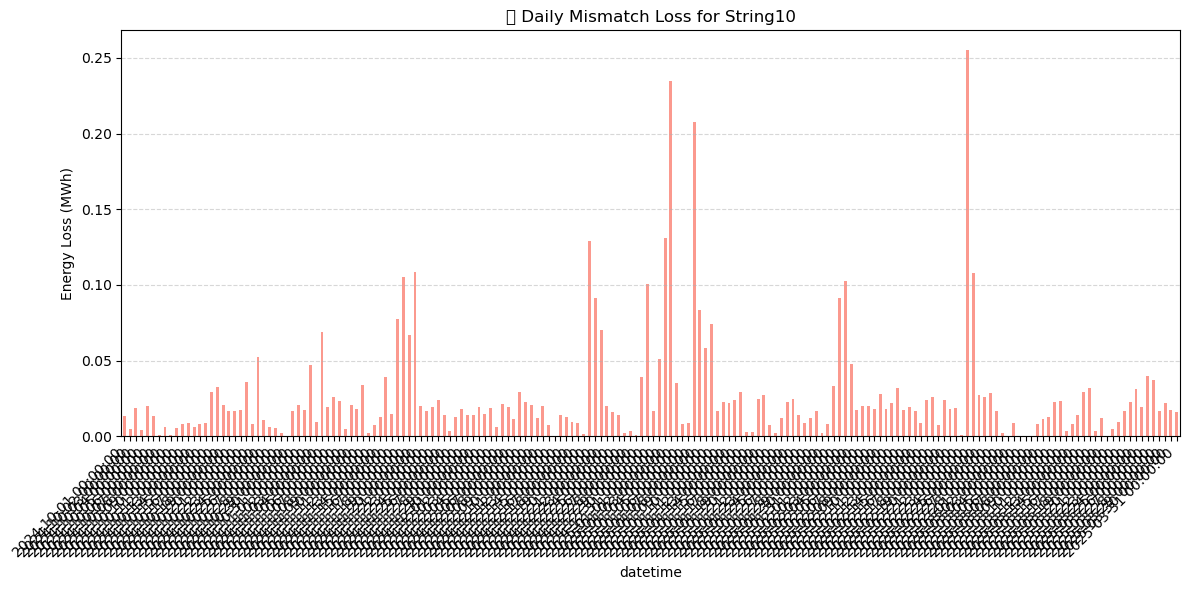

✅ Single mismatch loss plot done.


In [175]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
daily_mismatch.plot(kind='bar', color='salmon', alpha=0.8)
plt.ylabel('Energy Loss (MWh)')
plt.title('📉 Daily Mismatch Loss for String10')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("✅ Single mismatch loss plot done.")


C:\Users\dell\AppData\Local\Temp\ipykernel_9096\2598412185.py:21: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()


<Figure size 1400x700 with 0 Axes>

C:\Users\dell\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


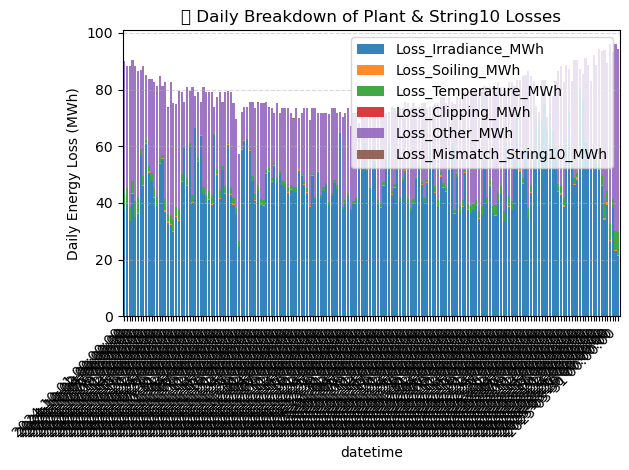

✅ Stacked daily loss breakdown plot done.


In [179]:
# First, make sure we have daily sums of all losses
daily_losses['Loss_Mismatch_String10_MWh'] = daily_mismatch

# Select columns to plot
cols_for_plot = [
    'Loss_Irradiance_MWh', 
    'Loss_Soiling_MWh', 
    'Loss_Temperature_MWh', 
    'Loss_Clipping_MWh', 
    'Loss_Other_MWh', 
    'Loss_Mismatch_String10_MWh'
]

# Plot as stacked bar chart
plt.figure(figsize=(14, 7))
daily_losses[cols_for_plot].plot(kind='bar', stacked=True, alpha=0.9, width=0.8)

plt.ylabel('Daily Energy Loss (MWh)')
plt.title('🔍 Daily Breakdown of Plant & String10 Losses')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("✅ Stacked daily loss breakdown plot done.")


In [181]:
# Save daily_losses DataFrame to CSV
daily_losses.to_csv('daily_losses_with_mismatch.csv')

print("✅ Saved: daily_losses_with_mismatch.csv")


✅ Saved: daily_losses_with_mismatch.csv


In [184]:
# If you want all:
hourly_losses.to_csv('hourly_losses.csv')
weekly_losses.to_csv('weekly_losses.csv')
monthly_losses.to_csv('monthly_losses.csv')

print("✅ (Optional) Other CSVs saved too")

✅ (Optional) Other CSVs saved too


In [186]:
daily_mismatch.to_csv('daily_mismatch_loss_string10.csv', header=True)

print("✅ Saved: daily_mismatch_loss_string10.csv")


✅ Saved: daily_mismatch_loss_string10.csv


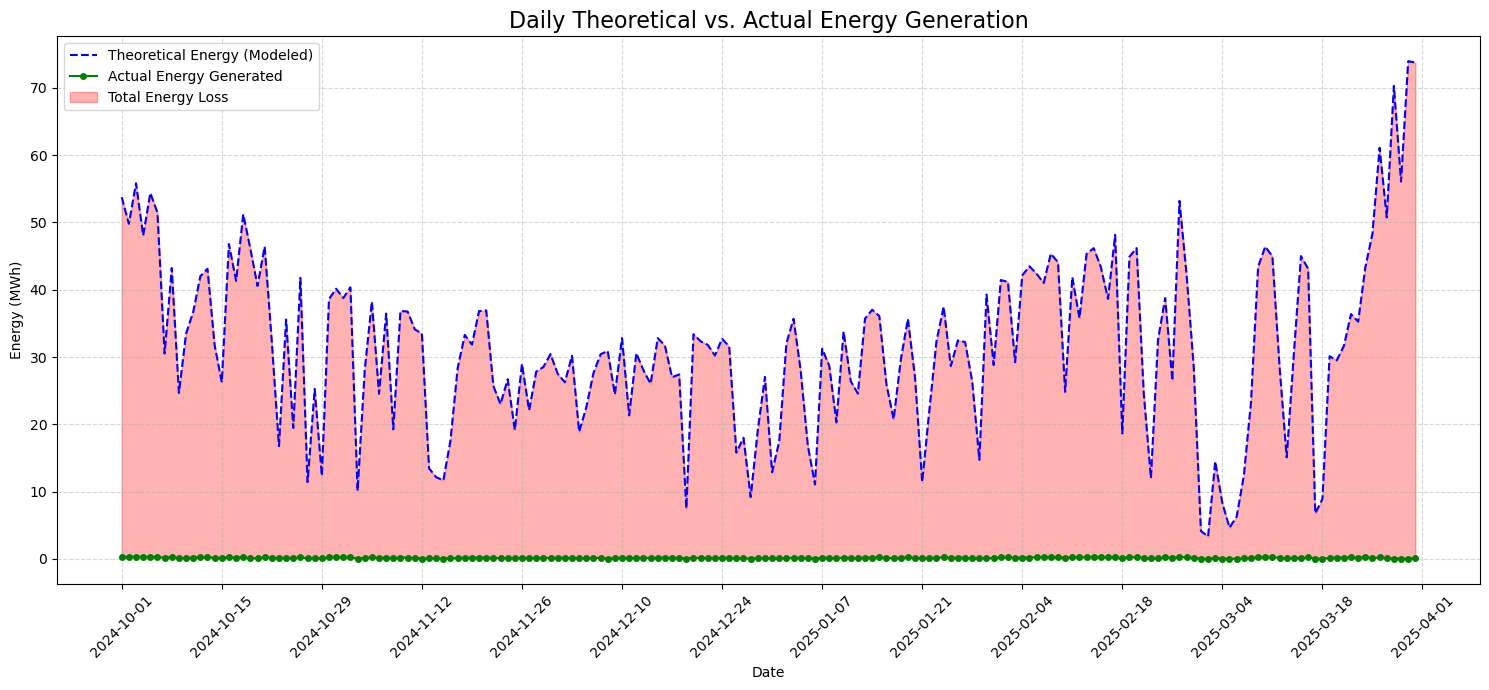

In [188]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Use the daily aggregated data
plot_data = daily_losses

fig, ax = plt.subplots(figsize=(15, 7))

# Plot theoretical and actual energy
ax.plot(plot_data.index, plot_data['Total_Theoretical_Energy_MWh'],
        label='Theoretical Energy (Modeled)', color='blue', linestyle='--')
ax.plot(plot_data.index, plot_data['Actual_Plant_Energy_MWh'],
        label='Actual Energy Generated', color='green', marker='o', markersize=4)

# Fill area between to show total loss visually
ax.fill_between(plot_data.index,
                plot_data['Actual_Plant_Energy_MWh'],
                plot_data['Total_Theoretical_Energy_MWh'],
                color='red', alpha=0.3, label='Total Energy Loss')

# Formatting
ax.set_title('Daily Theoretical vs. Actual Energy Generation', fontsize=16)
ax.set_ylabel('Energy (MWh)')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# Improve x-axis date labels
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))  # tick every 2 weeks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


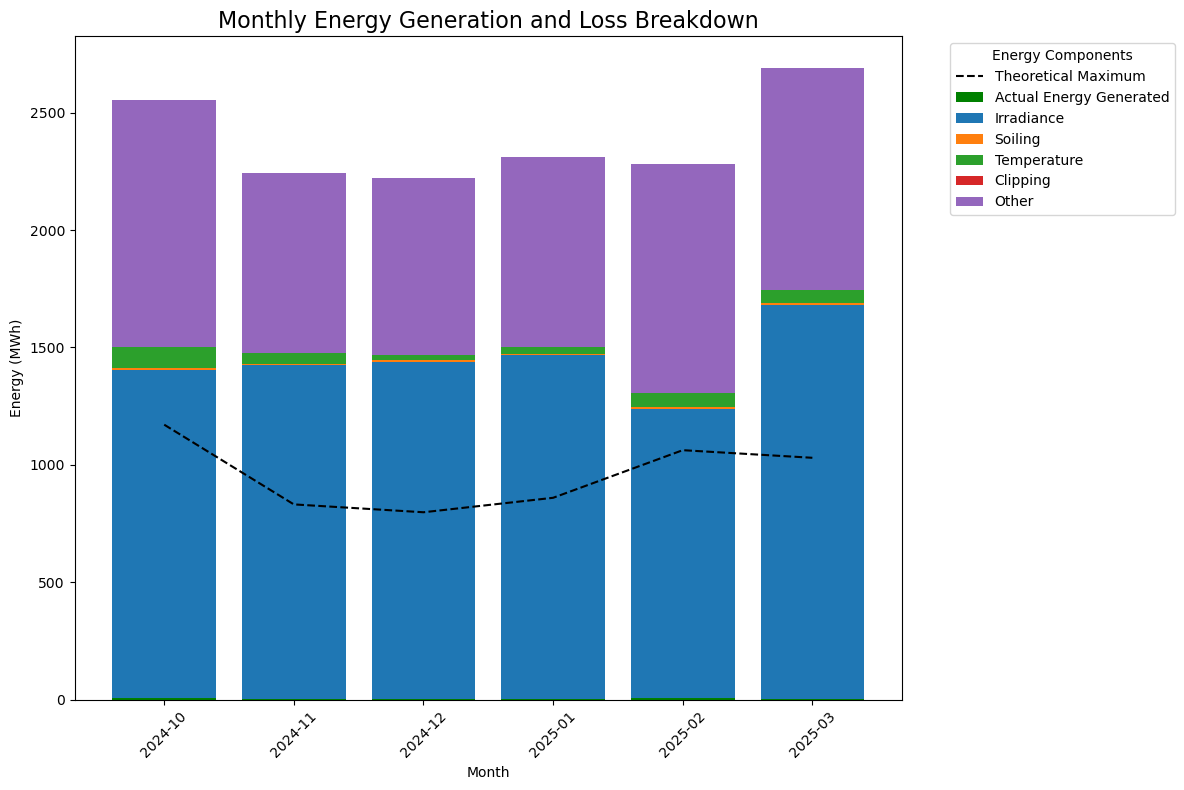

In [190]:
# Use the monthly aggregated data
plot_data = monthly_losses

# Loss columns in logical order
loss_cols_to_plot = [
    'Loss_Irradiance_MWh', 
    'Loss_Soiling_MWh', 
    'Loss_Temperature_MWh', 
    'Loss_Clipping_MWh', 
    'Loss_Other_MWh'
]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Start with actual energy as the base
ax.bar(plot_data.index.strftime('%Y-%m'),
       plot_data['Actual_Plant_Energy_MWh'],
       label='Actual Energy Generated', color='green')

# Stack each loss component
bottom_bar = plot_data['Actual_Plant_Energy_MWh'].copy()
for loss_col in loss_cols_to_plot:
    ax.bar(plot_data.index.strftime('%Y-%m'),
           plot_data[loss_col],
           bottom=bottom_bar,
           label=loss_col.replace('_MWh', '').replace('Loss_', ''))
    bottom_bar += plot_data[loss_col]

# Plot the theoretical max line
ax.plot(plot_data.index.strftime('%Y-%m'),
        plot_data['Total_Theoretical_Energy_MWh'],
        color='black', linestyle='--', label='Theoretical Maximum')

# Formatting
ax.set_title('Monthly Energy Generation and Loss Breakdown', fontsize=16)
ax.set_ylabel('Energy (MWh)')
ax.set_xlabel('Month')
plt.xticks(rotation=45)
ax.legend(title='Energy Components', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


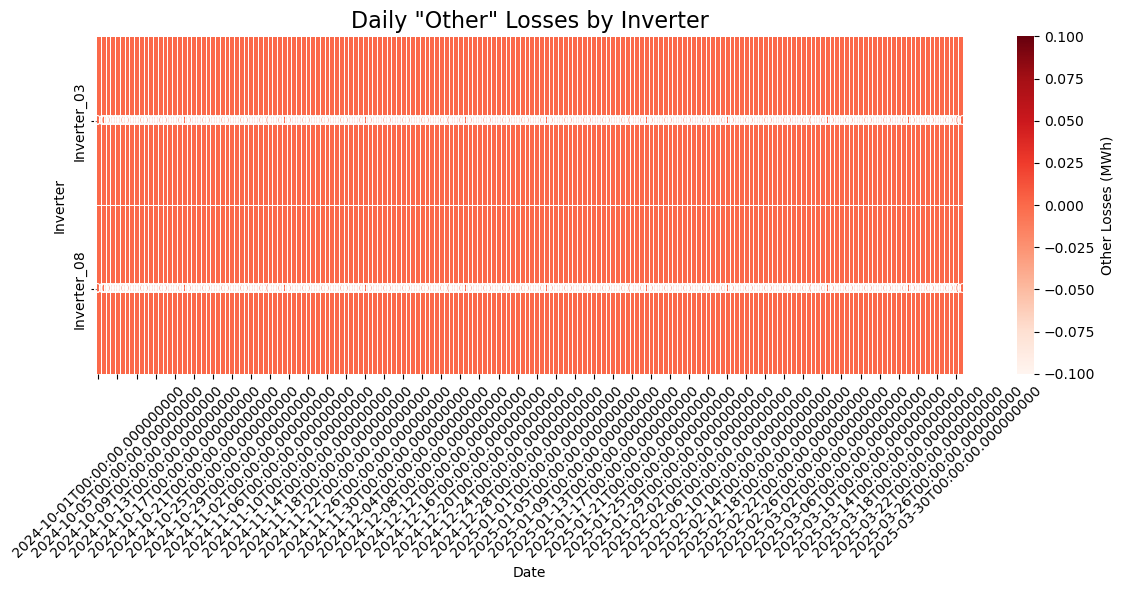

In [192]:
import seaborn as sns
import matplotlib.pyplot as plt

# First, resample daily and convert MW to MWh (×0.25 for 15 min intervals)
inv_other_loss_daily = df.resample('D')[['Loss_Other_Inv03_MW', 'Loss_Other_Inv08_MW']].sum() * 0.25
inv_other_loss_daily.columns = ['Inverter_03', 'Inverter_08']  # rename for clarity

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    inv_other_loss_daily.transpose(),   # transpose to get inverters on y-axis
    cmap='Reds',
    annot=True,
    fmt=".1f",        # format numbers to 1 decimal
    linewidths=.5,
    cbar_kws={'label': 'Other Losses (MWh)'}
)

plt.title('Daily "Other" Losses by Inverter', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Inverter')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


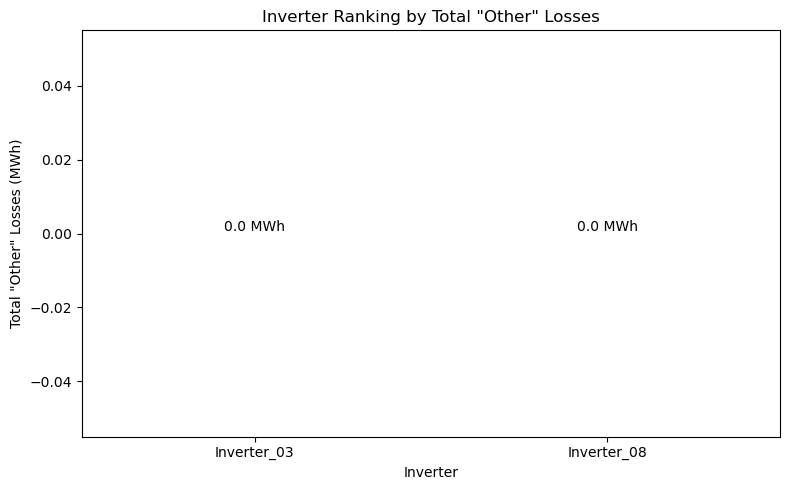

In [194]:
import matplotlib.pyplot as plt

# Calculate total 'Other' losses over full period (convert to MWh)
total_loss_inv03 = df['Loss_Other_Inv03_MW'].sum() * 0.25
total_loss_inv08 = df['Loss_Other_Inv08_MW'].sum() * 0.25

# Put into a dictionary
inverter_losses = {
    'Inverter_03': total_loss_inv03,
    'Inverter_08': total_loss_inv08
}

# Sort descending
sorted_inverters = sorted(inverter_losses.items(), key=lambda x: x[1], reverse=True)
inverter_names = [item[0] for item in sorted_inverters]
loss_values = [item[1] for item in sorted_inverters]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(inverter_names, loss_values, color=['#d9534f', '#5cb85c'])  # red for worse, green for better
plt.bar_label(bars, fmt='%.1f MWh')

plt.title('Inverter Ranking by Total "Other" Losses')
plt.ylabel('Total "Other" Losses (MWh)')
plt.xlabel('Inverter')
plt.tight_layout()
plt.show()
